In [ ]:
! git clone https://github.com/DS3001/group9

Cloning into 'group9'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 292 (delta 147), reused 135 (delta 70), pack-reused 9
Receiving objects: 100% (292/292), 131.03 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (147/147), done.


## Programming Lab #2
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that predict the likelihood a person has a stroke. The data include:
  
  - `age`: Patient age, numeric
  - `avg_glucose_level`: Blood sugar levels, numeric
  - `bmi`: Body mass index, numeric
  - `ever_married`: Ever married, dummy/character (Yes, No)
  - `gender`: Male, Female, or Other, character
  - `heart_disease`: Has heart disease, dummy
  - `hypertension`: Has hypertension, dummy
  - `id`: Study identification number
  - `Residence_type`: Type of residence, dummy/character (Urban, Rural)
  - `smoking_status`: Former, never, or current smoker, categorical
  - `work_type`: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (`Private`), Self-employed (`Self-employed`)
  - `stroke`: Suffered a stroke in the sample period
  
The data come in two files: `training_data.csv`, which you should use to build your models, and `testing_data.csv`, which you should use to test your models. The models must be trained on the training data and tested on the testing data, but providing both files allows you to experiment with your choices and iterate on model designs. If performance drops on the testing data, you know there's a problem.
  
You can use any of the tools presented in class: $k$ nearest neighbor, linear models, or decision trees. In principle, $k$ means clustering might also be helpful for looking for patterns in the data that the other methods might miss. Using canned versions of more advanced tools (boosting, bagging, random forests, neural networks, etc.) is deeply unsporting and thus not allowed. You can be creative about transforming variables, or combining decision trees with linear models or $k$NN. Try something interesting. Fail extravagantly. The goal is to work on an intellectually interesting question that is similar to the tasks that data scientists are called on to do every day.
  
We will compare the groups' models to see if there are common trends or significant differences, and also to declare **The Winners** on the basis of whichever team achieves the lowest $RMSE$ on the testing data. A simple linear model with some polynomials and dummy variables achieves an $R^2$ of .087 and a $RMSE$ of .206.

# Summary

This project aims to develop accurate models for predicting stroke risk based on individual health factors. Our group shows that, unsurprisingly, direct health metrics such as glucose level are the most significant and accurate predictors of stroke. We specifically explore the influence of one’s age, BMI, smoking habits, hypertension, and glucose level. While creating models, it is also crucial to investigate the accuracy in their predictions, so this included evaluations of the R-squared value and root mean standard error (RMSE). According to the CDC, (https://www.cdc.gov/stroke/facts.htm) every year, more than 795,000 people have strokes in the U.S. The vast majority of these strokes are also first strokes. This is a highly important topic to investigate, because early stroke detection and preventative measures are crucial for reducing stroke severity while improving patient outcomes. By identifying individuals with high risk factors, health professionals can intervene proactively. This research also allows us to detect early signs that someone is going to have a stroke, which can cause the severity of damage to be potentially reduced.

Our approach involves extensive feature engineering, including feature selection, data cleaning and preprocessing, and creating interactions within the data. Specifically, we created linear regression models which give us insight into how certain health risks (such as one’s BMI or smoking habits) which allows us to analyze the relationships between risk factors and stroke occurrence, and utilizing decision trees to see what health risk may present as the highest risk factor for stroke susceptibility. For each model, we evaluated its accuracy and  modified them to narrow down the most impactful risk factors, and potentially increase the model’s accuracy in prediction. We computed more advanced decision trees with dummy and continuous variables, which had slightly lower RMSE's, but valuable insights into certain variables. A random forest model was also implemented to experiment with even more advanced modeling in hopes to come to a more accurate stroke prediction.


# Data

**Initial Data Analysis**

The dataset presented many variable types (dummy, categorical, numeric) that measured many different areas. For example, “bmi,” “avg_glucose_level,” “heart_disease,” and “hypertension” are all biological variables that are acutely associated with a person's overall health and wellbeing. Each of these variables is commonly measured at a doctors office and recorded on medical records. The “residence_type,” “work_type,” and “ever_married” variables are more likely to be asked on a census or social survey. As we discussed our approach to the project, we considered how we would use each variable/groups of variables to predict the likelihood of a stroke. We agreed that both biological and social variables could be useful in our predictive models. However, we also agreed that the “biological” variables tended to have a more direct and causal relationship with the risk of a stroke. For example, high glucose levels can clog blood vessels and restrict the blood supply to the brain, and high blood pressure can cause arteries to burst. Someone’s residence type or occupation may be correlated with the risk of a stroke, but does not cause a stroke like high glucose levels or high blood pressure. For these reasons, we decided to give more weight to the biological variables presented in the dataset.

**Data Sensitivity, Fairness, and Privacy**

Our group considered the ramifications of the data used in our model. There are large risks involved in the collection, storage, and use of our dataset. Some variables contain highly personal information that patients may not want to share with the general public. Given the alarmingly high number of healthcare data breaches in the past few years, it is critical that these data be handled with utmost privacy and respect for the wishes of each patient. Great steps must be taken to obscure the individual identity of each patient included in the dataset and each patient that uses the model.

**Data Cleaning and Preprocessing**

We began the visual analysis of our key variables by placing them side-by-side in boxplots. The “avg_glucose_level” and “bmi” variables had a far larger spread than the “age,” “hypertension,” “heart_disease,” and “stroke” variables, so we used an arcsinh transformation to make them comparable. The “avg_glucose_level” variable posed a challenge because it yielded many outliers, even after the arcsinh transformation. Therefore, we decided to “winsorize” the variable to limit the effect of outliers on our predictions. We addressed our categorical variables by converting the “ever_married” and “gender” variables to dummy variables, and one hot encoding the “smoking_status” variable. We then cleaned the data of NANs. Overall, the given dataset was clean and required relatively little data cleaning. We were able to implement the variables into our models without any major difficulties.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('./group9/project_2/data/training_data.csv')
df_test = pd.read_csv('./group9/project_2/data/testing_data.csv')

y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())


In [ ]:
## Linear Model (For Comparison)
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#
dummies = pd.concat([ pd.get_dummies(X_train['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_train = pd.concat([continuous,dummies],axis=1)

X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

dummies = pd.concat([ pd.get_dummies(X_test['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_test = pd.concat([continuous,dummies],axis=1)

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   # R squared measure




R2:  0.08717964343852191
RMSE:  0.20599583849612824


## Initial data imputations, transformations, and encoding

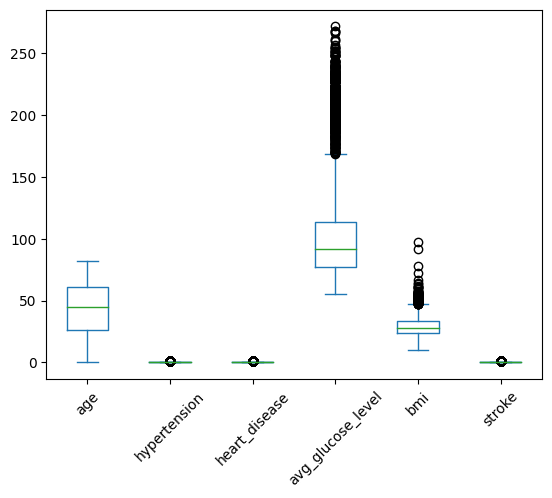

In [ ]:
#### avg_glucose_level and bmi could use an arcsinh transformation
plt = df_train.drop('id', axis=1).drop('Unnamed: 0', axis=1).plot.box(rot=45)

In [ ]:
df_train.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,2465,68685,Male,36.0,0,0,Yes,Govt_job,Urban,65.87,32.2,formerly smoked,0
1,4311,59058,Female,45.0,0,0,Yes,Govt_job,Rural,68.66,25.3,never smoked,0
2,2375,46068,Male,58.0,0,0,No,Self-employed,Rural,170.93,30.7,Unknown,0
3,5017,36837,Female,61.0,0,0,Yes,Self-employed,Urban,69.88,27.1,never smoked,0
4,753,30550,Female,78.0,0,0,No,Private,Urban,103.86,30.6,Unknown,0


In [ ]:
# change ever_married to dummy
temp = df_train['ever_married'].replace('Yes', 1).replace('No', 0)
df_train['ever_married'] = temp


temp = df_test['ever_married'].replace('Yes', 1).replace('No', 0)
df_test['ever_married'] = temp


# investigate smoking_status
df_train['smoking_status'].unique() # should one hot encode these
ohe = pd.get_dummies(df_train['smoking_status'])

temp = pd.concat([df_train, ohe], axis=1)
temp = temp.drop('smoking_status', axis=1)
temp = temp.drop('Unknown', axis=1) # drop 'unknown' values from `smoking_status`
df_train_ohe = temp



df_test['smoking_status'].unique() # should one hot encode these
ohe = pd.get_dummies(df_test['smoking_status'])

temp = pd.concat([df_test, ohe], axis=1)
temp = temp.drop('smoking_status', axis=1)
temp = temp.drop('Unknown', axis=1) # drop 'unknown' values from `smoking_status`
df_test_ohe = temp



df_train_ohe.head()
df_test_ohe.head()


,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,formerly smoked,never smoked,smokes
0,251,30468,Male,58.0,1,0,1,Private,Urban,87.96,39.2,0,0,1,0
1,252,16523,Female,8.0,0,0,0,Private,Urban,110.89,17.6,0,0,0,0
2,253,56543,Female,70.0,0,0,1,Private,Rural,69.04,35.9,0,1,0,0
3,255,32257,Female,47.0,0,0,1,Private,Urban,210.95,50.1,0,0,0,0
4,259,28674,Female,74.0,1,0,1,Self-employed,Urban,205.84,54.6,0,0,1,0


<Axes: >

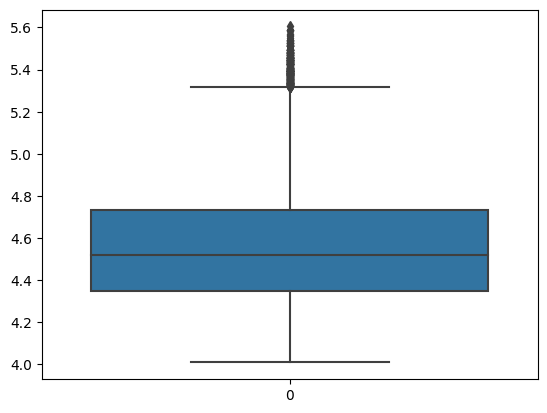

In [ ]:
# arcsinh transformation on avg_glucose_level for better data distribution
df_train_ohe['avg_glucose_level'].describe()

#sns.kdeplot(df_train_ohe['avg_glucose_level'])

df_train_ohe['avg_glucose_level'] = np.log(df_train_ohe['avg_glucose_level'])
sns.boxplot(df_train_ohe['avg_glucose_level']) # still lots of outliers, lets 'windsorise' this variable

In [ ]:
# all clean of nans
df_train_ohe['age'].unique()
df_train_ohe['hypertension'].unique()
df_train_ohe['heart_disease'].unique()
df_train_ohe['work_type'].unique()
df_train_ohe['Residence_type'].unique()
df_train_ohe['avg_glucose_level'].unique()

df_train_ohe['bmi'] = df_train['bmi'].fillna(df_train['bmi'].mean())
df_train_ohe['bmi'].unique()

df_test_ohe['bmi'] = df_test['bmi'].fillna(df_test['bmi'].mean())
#df_test_ohe['bmi'].unique()

# DT with smoking_status encoded

In [ ]:
# prepare variables for tree classification
### all categoricals w/ binary or one_hot_encoding

# FEMALE: 0, MALE: 1, OTHER: .5

temp = df_train['gender'].replace("Female", 0).replace("Male", 1).replace("Other",.5)
df_train_ohe['gender'] = temp

temp = df_test['gender'].replace("Female", 0).replace("Male", 1)
df_test_ohe['gender'] = temp


In [ ]:
X_train = df_train_ohe[['hypertension', 'heart_disease', 'ever_married', 'never smoked', 'formerly smoked', 'smokes', 'gender', 'avg_glucose_level']]
y_train = df_train_ohe['stroke']

X_test = df_test_ohe[['hypertension', 'heart_disease', 'ever_married', 'never smoked', 'formerly smoked', 'smokes', 'gender', 'avg_glucose_level']]
y_test = df_test_ohe['stroke']

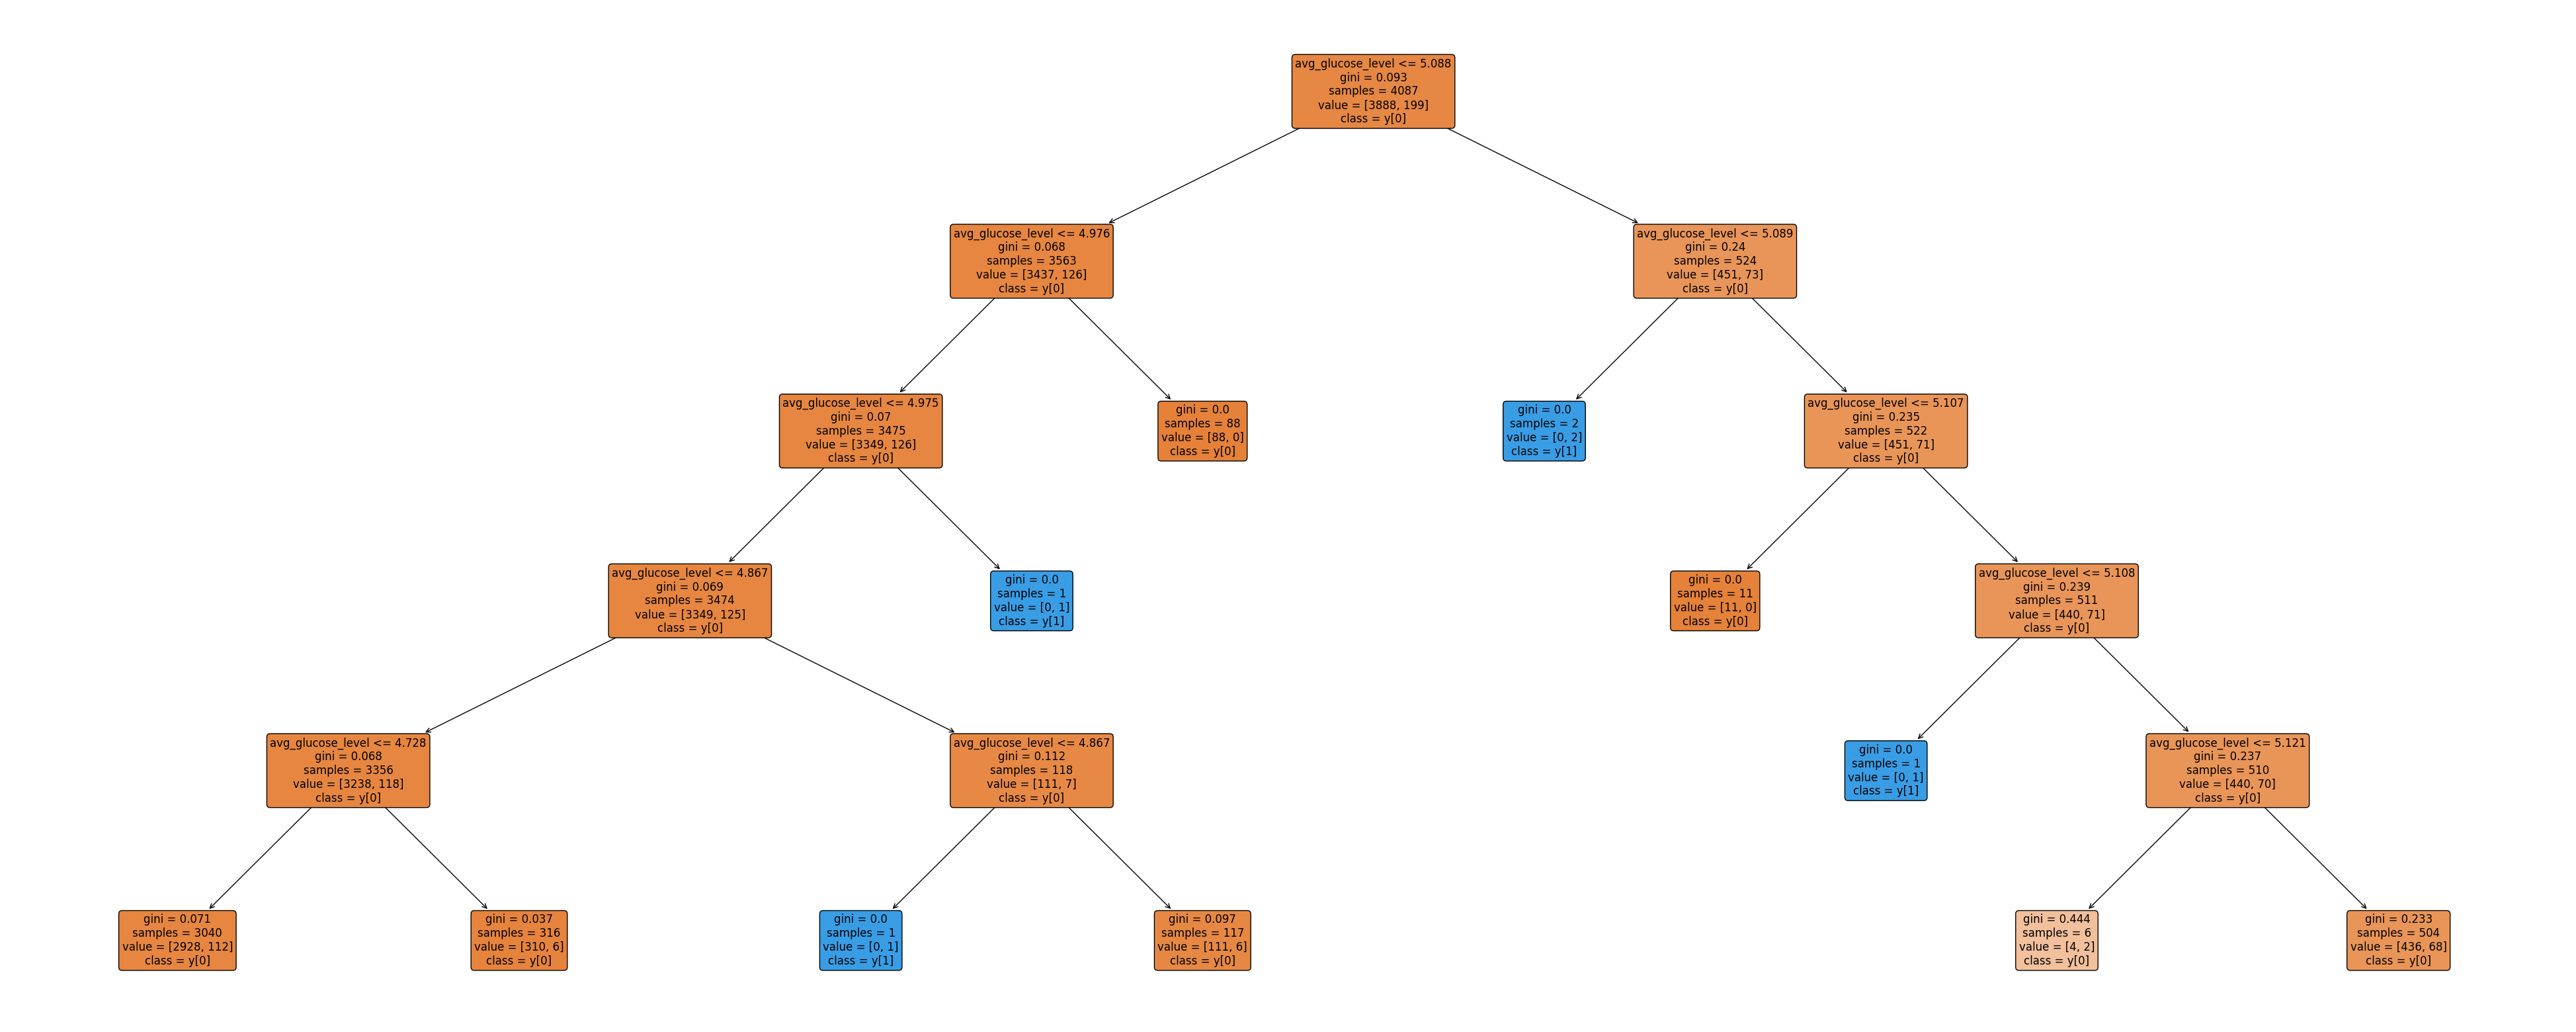

In [ ]:
## Decision Tree
from sklearn import tree
import matplotlib.pyplot as plt


model1 = tree.DecisionTreeClassifier(max_depth=5) # Fit model for visualization
cart1 = model1.fit(X_train, y_train)
plt.figure(figsize=(50,20)) # Adjust the size as needed
tree.plot_tree(cart1,
               filled=True,
               feature_names=X_train.columns,
               class_names=True,
               rounded=True,
               fontsize=12)
plt.show()
#print(model1.feature_importances_)



In [ ]:

model = tree.DecisionTreeClassifier() # Fit model for analysis, no max depth
cart = model.fit(X_train, y_train)

<Axes: >

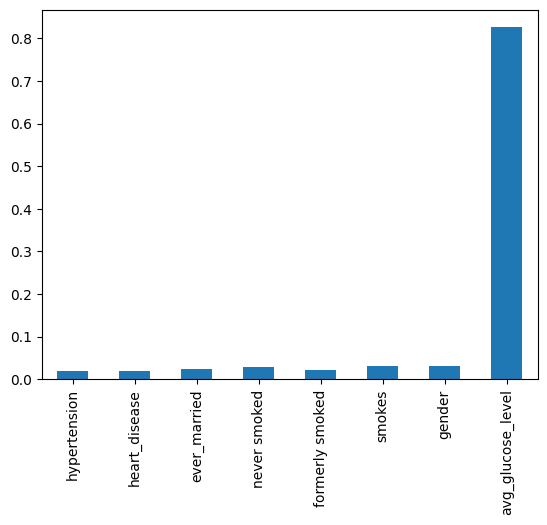

In [ ]:
# Variable importance plot:
dt_importances = pd.Series(cart.feature_importances_, index=X_train.columns )
dt_importances.plot.bar()
# visualization of feature importances. good to move forward

0.2360476118780145
[0 1]


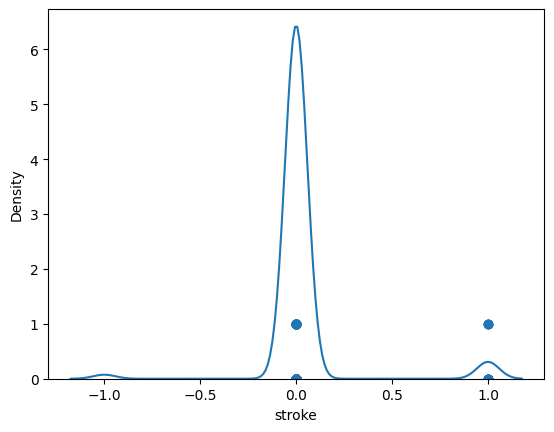

In [ ]:

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)

## True versus predicted plot:
plt.scatter(y_hat_cart,y_test)

SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/len(y_test))*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/len(y_test))**(1/2)

TSS = np.sum( (y_test - y_train.mean())**2 ) # found in model_evaluation doc

R2_cart = 1 - SSE_cart/TSS

print(RMSE_cart)
print(np.unique(y_hat_cart))

# Results

Decision Tree.

Our first more advanced model is the decision tree. The decision tree works by creating strategic splits to determine categorical outcomes. This model makes logical sense for a model such as health outcomes. It is not unlikely that many people have experienced a situation in which one’s doctor asks a series of health questions to obtain a predictive diagnosis. This model works in a very similar way. In doing so the model is able to trade expertise and experience for incredible amounts of raw data in order to make predictions.


The model uses several key dummy variables as well as a one continuous variable, average glucose level, to make categorical predictions on stroke outcome. The first major split is on glucose level <= 5.088 creating a 3563/524 split. The right branch, suggesting high glucose levels, has a 73/451 = .161 Strok:NoStroke ratio while the lower glucose level left branch has a 126/3437 = .036 Stroke:NoStroke ratio. It therefore makes sense that the model would find this to be a strong first split since the groups show such varying outcome ratios. The model finds its first terminal node following the right branch. Subsequent decisions show that no heart disease and low glucose (within the set of avg_glucose_level>=5.088) find the quickest terminal node. It appears the model relies heavily on average glucose. With each split further refinement is found through precision in exact glucose level. This would make sense since almost all of the other variables are binary. As such glucose level is the only place where the model is able to make anything other than binary splits.

Additionally binary variables describing marriage occur frequently and appear for the first time within the third layer of the tree. It is interesting to consider why marriage status has an effect on stroke outcome or if there may be a form of omitted variable bias applying extra predictive weight to marital status. The leftmost occurrence of ever_married splits the data 1287/1891, with the left branch (no marriage) showing a .0117 Stroke:NoStroke ratio and right branch (marriage) showing a .0379 Stroke:NoStroke ratio. The rightmost appearance shows a 19/168 split with a left side .267 Stroke:NoStroke ratio and right side .05 Stroke:Nostroke ratio. Thus it appears that the impact of marriage increases the chance of stroke in the generally healthier left branch while the generally less healthy right branch unmarried people are more likely to have a stroke. This could occur for many reasons but will likely occur due to some omitted variable which biases the impact of marriage. While marriage can single out many attributes from the inherent partnership relationship, however it seems less likely that marriage so strongly predicts stroke. Other variables make far more sense such as ever smoked, which has direct health outcomes.

When considering the predictive significance the RMSE is found to be .236. When compared to the base linear model with an RMSE of .206 this model is in fact worse. This could be due to a variety of decisions such as only including dummy variables, leading the model to rely very heavily on the one continuous variable, glucose level. In our subsequent models we hope to find more nuanced models that will help to have better predictive statistics.


# Feature engineering for better results

In [ ]:
# create bmi grouping variable
underweight_threshold = 18.5
normal_threshold = 24.9
overweight_threshold = 29.9

# Create a new column 'BMI Classification' based on BMI values
df_train_ohe['bmi_group'] = pd.cut(df_train_ohe['bmi'],
                                   bins=[0, underweight_threshold, normal_threshold, overweight_threshold, float('inf')],
                                   labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
                                   right=False)

df_test_ohe['bmi_group'] = pd.cut(df_test_ohe['bmi'],
                                   bins=[0, underweight_threshold, normal_threshold, overweight_threshold, float('inf')],
                                   labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
                                   right=False)

pd.crosstab(df_train_ohe['bmi_group'], df_train_ohe['stroke'])

stroke,0,1
bmi_group,,
Underweight,270,1
Normal,924,31
Overweight,1216,85
Obese,1478,82


Looking at the crosstab between stroke and BMI groups, it is clear that weight is an important explanatory factor for stroke prediction. 167/199 or 83.9% of individuals who had a stroke were at least classified as overweight based on their BMI.


In [ ]:
pd.crosstab(df_train_ohe['gender'], df_train_ohe['stroke'])

stroke,0,1
gender,,
0.0,2286,112
0.5,1,0
1.0,1601,87


In [ ]:
# One-hot-encode new 'bmi_group' variable
temp = pd.get_dummies(df_train_ohe['bmi_group'])
temp = pd.concat([df_train_ohe, temp], axis=1)
df_train_ohe = temp

temp = pd.get_dummies(df_test_ohe['bmi_group'])
temp = pd.concat([df_test_ohe, temp], axis=1)
df_test_ohe = temp

df_test_ohe.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,formerly smoked,never smoked,smokes,bmi_group,Underweight,Normal,Overweight,Obese
0,251,30468,1,58.0,1,0,1,Private,Urban,87.96,39.2,0,0,1,0,Obese,0,0,0,1
1,252,16523,0,8.0,0,0,0,Private,Urban,110.89,17.6,0,0,0,0,Underweight,1,0,0,0
2,253,56543,0,70.0,0,0,1,Private,Rural,69.04,35.9,0,1,0,0,Obese,0,0,0,1
3,255,32257,0,47.0,0,0,1,Private,Urban,210.95,50.1,0,0,0,0,Obese,0,0,0,1
4,259,28674,0,74.0,1,0,1,Self-employed,Urban,205.84,54.6,0,0,1,0,Obese,0,0,0,1


In [ ]:
pd.crosstab(df_train_ohe['gender'], df_train_ohe['stroke'])
print("Percent of females with stroke: ", (112/2286)*100)
print("Percent of males with stroke: ", (87/1601)*100)

Percent of females with stroke:  4.899387576552931
Percent of males with stroke:  5.434103685196752


<ipython-input-21-2aa2295d2d7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-21-2aa2295d2d7a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker
<ipython-input-21-2aa2295d2d7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-21-2aa2295d2d7a>:14: SettingWithCopyW

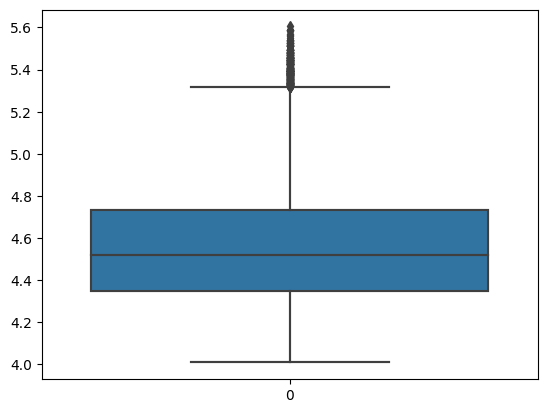

In [ ]:
sns.boxplot(df_train_ohe['avg_glucose_level']) # still lots of outliers, lets 'windsorise' this variable

## Function to compute whiskers:                      # gotten from model_evaluation.ipynb
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

sns.boxplot( windsorize(df_train_ohe['avg_glucose_level'])) # looks better
df_train_ohe['avg_glucose_level'] = windsorize(df_train_ohe['avg_glucose_level'])

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


<ipython-input-21-2aa2295d2d7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-21-2aa2295d2d7a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


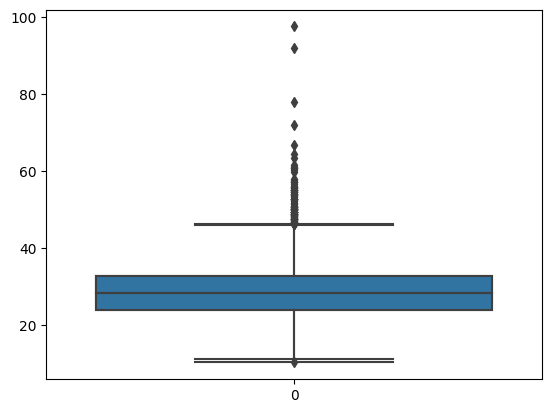

In [ ]:
print(sns.boxplot(df_train_ohe['bmi']))
df_train_ohe['bmi'] = windsorize(df_train_ohe['bmi'])
print(sns.boxplot(df_train_ohe['bmi']))

Axes(0.125,0.11;0.775x0.77)


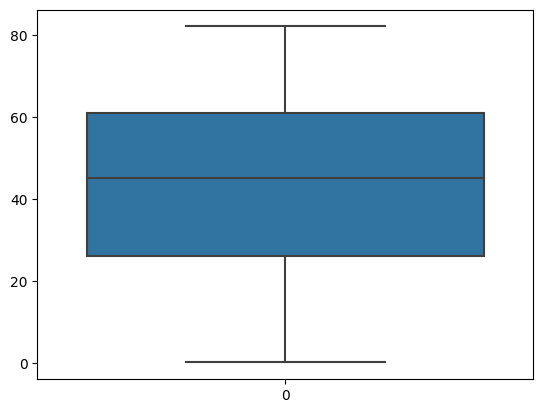

In [ ]:
print(sns.boxplot(df_train_ohe['age'])) ##see if there are any outliers

# DT with winsorized `avg_glucose_level` and `bmi`

In [ ]:
#X_train = df_train_ohe[['hypertension', 'heart_disease', 'smokes', 'gender', 'avg_glucose_level', 'Normal', 'Underweight', 'Overweight', 'Obese']]
#y_train = df_train_ohe['stroke']

#X_test = df_test_ohe[['hypertension', 'heart_disease', 'smokes', 'gender', 'avg_glucose_level', 'Normal', 'Underweight', 'Overweight', 'Obese']]
#y_test = df_test_ohe['stroke']

In [ ]:
# only include vars with high feature importances as pictured above "# Variable importance plot:""
X_train = df_train_ohe[['hypertension', 'heart_disease', 'smokes','gender',  'avg_glucose_level', 'bmi', 'age']]
y_train = df_train_ohe['stroke']

X_test = df_test_ohe[['hypertension', 'heart_disease', 'smokes', 'gender', 'avg_glucose_level', 'bmi', 'age']]
y_test = df_test_ohe['stroke']


[0.         0.02378741 0.         0.04804499 0.25465444 0.1023898
 0.57112337]
0.22107884414269094


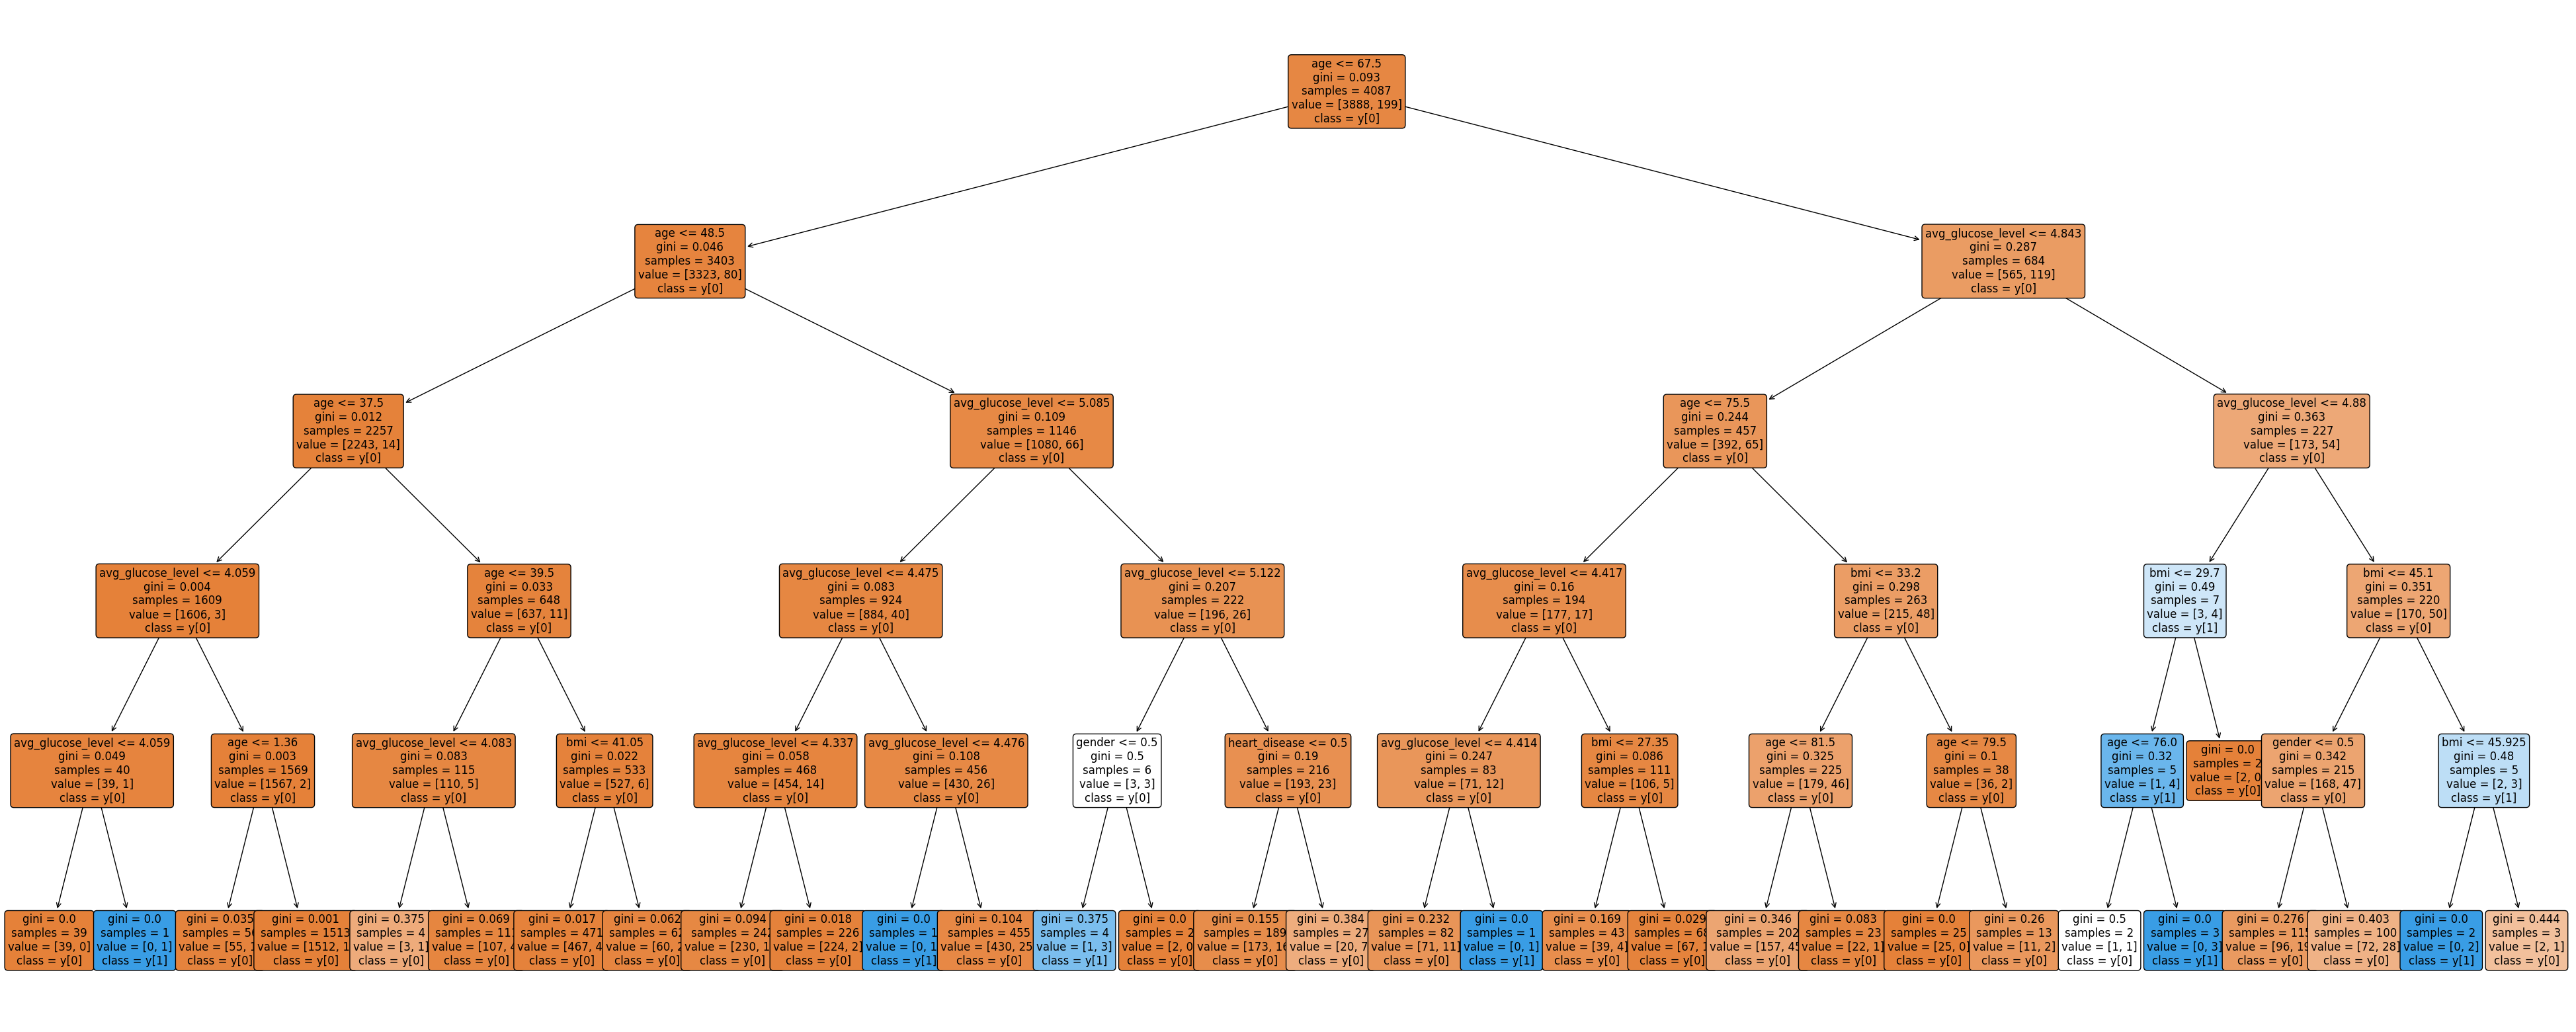

In [ ]:
## Decision Tree
from sklearn import tree
import matplotlib.pyplot as plt

model = tree.DecisionTreeClassifier(max_depth=5) # Fit the classifier
cart = model.fit(X_train, y_train)
plt.figure(figsize=(50,20)) # Adjust the size as needed
tree.plot_tree(cart,
               filled=True,
               feature_names=X_train.columns,
               class_names=True,
               rounded=True,
               fontsize=12)

print(model.feature_importances_)
## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/len(y_test))*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/len(y_test))**(1/2)

TSS = np.sum( (y_test - y_train.mean())**2 ) # found in model_evaluation doc

R2_cart = 1 - SSE_cart/TSS

print(RMSE_cart)

After looking deeper into BMI and understanding its importance to the model, we ran a second decision tree, adding variables we thought would be important, including “age,” “gender,” and “bmi” and removing variables such as “ever_married” that we deemed insignificant for the model. The results for the new decision tree with a winsorized avg_glucose_level and bmi are promising and improve upon the initial model. The RMSE improved to a 0.221, which is better than the original decision tree and suggests improved performance and accuracy in predictions. However, the RMSE is still slightly larger than the original linear mode, so more feature engineering might be necessary to transform data and make relationships in the data easier to capture.  

The new model adds two numeric, continuous variables to the original decision tree that are both used extensively to make stroke predictions. Compared to the first tree, the initial split in this classification is age at 67.5. At an age greater than 67, 119/199 or 59.8% of all strokes occurred. To continue, 119/684 or 17.4% of individuals over the age of 67 had a stroke. On the other hand, for those 67 and younger, 80/3403 or 2.35% of individuals had a stroke. As the root node of the tree, according to the algorithm's criteria, age is the best variable to separate the data with respect to the response variable, largely dictating the rest of the tree’s structure. This makes sense as an increase in age is correlated naturally with the narrowing of arteries. As clogged arteries are the primary cause of strokes, age is a very significant predictor. Another important node regarding “age” can be found going down the left side of the tree. For individuals with no other classification except below the age of 37.5, only 3/1609 or .1864% of individuals suffered a stroke. This figure alone displays how drastic changes in age play in stroke occurrences.

As the majority of strokes are located further down the right branches of the tree, the next significant variable in explaining variation in strokes among individuals is “avg_glucose_level.” At a glucose level of 4.843 mmol/L, the sample splits again, where the stroke to sample percentage in higher blood sugar levels is prevalent. For those that are over 67, higher blood sugar individuals had a 54/227 or 23.8% chance of having a stroke compared to the 65/457 or 14.223% chance in lower blood sugar individuals. Blood sugar levels are also deemed strong predictors in younger individuals. From the 3 individuals under 37.5 who had a stroke, all 3 of them also had a blood sugar level over 4.059 mmol/L.Once again, along with age, quanitiative health metrics directly related to the bloodstream and arteries are strong predictors.

In addition, there was a strong presence of BMI classifications throughout the bottom of the decision tree. All tree nodes classified with BMI all tended to be quite large in magnitude, which makes sense as the crosstab indicated earlier the strong correlation between overweight individuals and stroke instances. One interesting result is the correlation between BMI and stroke occurrences for individuals between 39 and 49. Here, the tree splits at a BMI of 41.05, which is considered morbidly obese. In this middle-age range, those that were morbidly obese had a 3.33% chance of having a stroke compared to a 0.8% chance for non-obese individuals. From these results, it is apparent that in middle-aged individuals, weight plays a significant role in predicting strokes.



<Axes: >

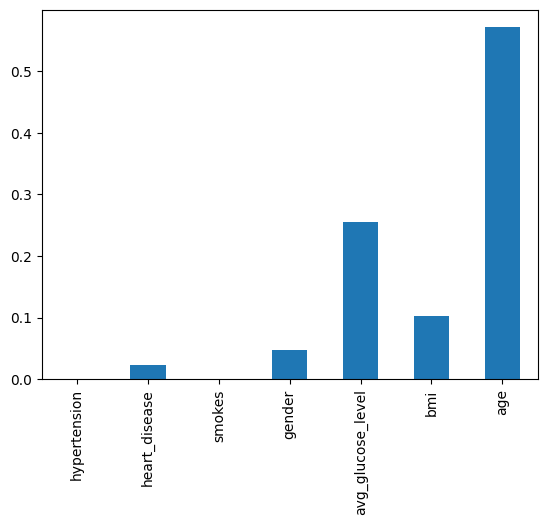

In [ ]:
#Variable importance plot:
dt_importances = pd.Series(cart.feature_importances_, index=X_train.columns )
dt_importances.plot.bar()

Looking at the variable importance plot, it is clear that age, BMI, and glucose levels all played significant roles in the decision tree’s classifications. Meanwhile, variables such as hypertension and smoking didn’t have any real importance to the model’s algorithm.

<Axes: xlabel='stroke', ylabel='Density'>

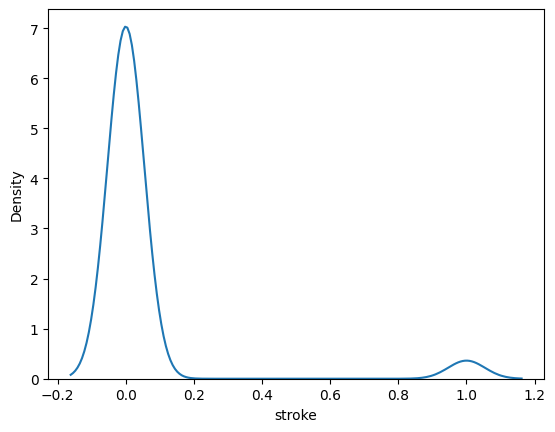

In [ ]:
## Residual plot:
sns.kdeplot(residuals_cart)

Above, the density at 0 represents the correctly predicted observations, while the density at -1 represents when participants did not experience a stroke when the model predicted they would, and the density at 1 represents when participants did experience a stroke and the decision tree predicted no stroke. Even though the RMSE of the model decreased compared to the original model, the model is not fit well enough. This is clear due to some residuals surrounding the 1, which would mean there are some False Negatives in the model. However, there are no more false positives, when comparing the first decision tree, so improvement was made to the model.

##2sls approach

In [ ]:

y_train = df_train_ohe['stroke']
y_test = df_test_ohe["stroke"]

In [ ]:
## 2SLS

#Create Instrument For hypertension
exo_x = df_train_ohe.loc[:,['age','bmi','gender','avg_glucose_level']]
endo_y = df_train_ohe.loc[:,['hypertension']]
stage1 = LinearRegression().fit(exo_x, endo_y) # Fit the linear model
IV_train = stage1.predict(exo_x)
IV_hyper = pd.DataFrame(data=IV_train, columns = ["IV_hyper"]) # Create a new, expanded dataframe

#Run Second Stage Regression
X_train = df_train_ohe.loc[:,['avg_glucose_level']]
Z_train = pd.concat([IV_hyper,X_train],axis=1)
stage2 = LinearRegression().fit(Z_train, y_train)

#Create Test Instrument
exo_xtest = df_test_ohe.loc[:,['age','bmi','gender','avg_glucose_level']]
endo_ytest = df_test_ohe.loc[:,['hypertension']]
stage1_test = LinearRegression().fit(exo_xtest, endo_ytest)
IV_test = stage1_test.predict(exo_xtest)
IV_hyper_test = pd.DataFrame(data=IV_test, columns = ["IV_hyper"]) # Create a new, expanded dataframe

#Test Regression
X_test = df_test_ohe.loc[:,['avg_glucose_level']]
Z_test = pd.concat([IV_hyper_test,X_test],axis=1)
y_hat_2SLS = stage2.predict(Z_test)

# Fit the model and get the R2 measure:
print('R2: ', stage2.score(Z_test, y_test)) # R squared measure
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat_2SLS)**2)/N )**.5 )

SSE_2SLS = np.sum( (y_test-y_hat_2SLS)**2 )
MSE_2SLS = (1/len(y_test))*np.sum( (y_test-y_hat_2SLS)**2 )
RMSE_2SLS = (SSE_2SLS/len(y_test))**(1/2)

TSS = np.sum( (y_test - y_train.mean())**2 ) # found in model_evaluation doc

R2_2SLS = 1 - SSE_2SLS/TSS

print("R2: " + str(R2_2SLS))
print("RMSE: " + str(RMSE_2SLS))


R2:  -0.14099631090215436
RMSE:  0.23030740860324667
R2: -0.1409954719237374
RMSE: 0.23030740860324667



For our final model we implemented a two stage least squares regression. This regression model seeks to tackle endogenous explanatory variables through a two stage regression approach. It is clear that hypertension, or high blood pressure, is a key indicator of stroke. However, we were interested in testing whether this was a causal relationship or simply reflected the reality that people who have high blood pressure tend to have other health complications as well.

To test this idea we used several exogenous variables as instruments for hypertension. These were age, bmi, and gender. All of these variables are both correlated with hypertension and we assume are uncorrelated with the structural model error. Thus this makes them valid and reasonable instruments for hypertension. For the first stage we regressed hypertension on these three instruments as well as average glucose level in order to create a prediction for hypertension based on the exogenous elements of the model. This effectively eliminated the potential for endogeneity within hypertension by making the new hypertension variable a fully exogenous prediction. For the second stage, stroke was regressed on instrumented hypertension and average glucose level. Therefore this would be a purely exogenous linear regression for stroke.

In order to test the model we allowed the testing data to create its own hypertension prediction. This was because the test of the model is in its ability to test stroke, not hypertension and as such an accurate prediction of hypertension is required to assess the model. The second stage regression was then tested by predicting the new prediction for hypertension as well as the testing data for glucose level.

The results were very poor. An R Squared of -.141 suggested that the model in fact went against the trends of the data and had no predictive qualities. The RMSE was more in line with what was expected at .230. If we prioritize RMSE then this would be an acceptable amount of error but with extreme caution due to the negative R squared value.

These results could have occurred for several reasons. First of all hypertension may not be endogenous, or there could have been other explanatory variables that were actually endogenous. If hypertension is not endogenous, then creating an instrument would have no benefit and in fact simply harm the previously strong predictive effect without eliminating bias. If other explanatory factors were actually endogenous such as glucose level then the model would continue to have bias and this could mean poor results. Overall the model is clearly flawed but does provide an interesting look at the endogeneity of different variables and could be improved for more predictive ability.





# Conclusion

Our team investigated approaches to attain highly accurate predictive models to assess the likelihood of a stroke to occur with continued trial and error. Furthermore, we aimed to identify the most influential predictor variables for a stroke by refining our models and employing more advanced techniques to have a higher accuracy of predictions.

Our findings gave us plenty of insight into what variables work best with refining the models. We began by looking into the given linear model that used factors that were most crucial to predicting a stroke, such as the person’s age, hypertension, heart disease, BMI, and average glucose level. This model, with polynomial and categorical features, achieved a RMSE of 0.206, which is a decent value for a more simple model.

We then began testing different decision tree models to see if we could achieve comparable results to the linear model. We thought a decision tree would be a valuable method as they can capture interactions between features and handle categorical variables more efficiently.  We began by creating a decision tree focussed around one continuous variable, average glucose, and other dummy variables. It was shown that the model relied heavily on glucose, making it a strong predictor for a stroke. However, this model achieved an RMSE of 0.236 which was worse than the initial linear model.

We then decided to create more advanced and ambitious models to see if there could be a higher prediction accuracy. After removing outliers from the average glucose level and BMI with an arcsinh transformation, we continued with our predictions. After the first decision tree, we wanted to add more continuous variables that we thought would be important for stroke prediction, including age and bmi. This model was an improvement from our first decision tree, because it achieved an RMSE of 0.221 as compared to 0.236. This decision tree gave us valuable insight into the importance of age as a predictor for strokes. It was found that if an individual was over 67, nearly 60% of all the strokes occurred. The average glucose level once again proved to be a highly important predictive factor. For the three individuals that had a stroke under the age of 37, all of them had higher glucose levels. Additionally, older individuals with higher glucose levels had more of a chance of having a stroke as compared to those with average levels. BMI also played a significant role in this model, with higher BMIs increasing the chances of stroke, especially in younger individuals.

Our final model was interested in the endogeneity of the hypertension variable. Overall, however, it was found the predictive properties of this model were very weak suggesting error in logic or execution. Tn the future we could test different variables as instruments to improve the model.

Overall, although the second decision tree gave us more accurate results, our model still suffered from false negatives and didn’t achieve the target RMSE below the initial linear regression that we hoped for. In the future, with additional feature engineering, we believe we can create a model that does improve upon the initial predictions of the linear regression.
Also, by using selection techniques to identify only most relevant features for the model, we can avoid many irrelevant or noisy features that make the model overly complex and prone the model to overfitting and thus a higher RMSE.

